# Clustering: Workout type analysis
Goal: Cluster users based on demographic and behavioral data to identify distinct types of gym-goers (e.g., frequent vs. infrequent users, location loyalty).
	• Tasks:
		○ Use clustering algorithms (e.g., k-means or hierarchical clustering) to group users based on age, gender, preferred exercise type, and check-in frequency.
		○ Interpret clusters to understand user segments, such as “young frequent users” or “occasional users in older age groups.”
		○ Visualize clustering results to illustrate user segments and their characteristics.
	• Course Topic Covered: Clustering - week 6

### 1. Load and handle data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
checkin_data = pd.read_csv("../data/_raw/checkin_checkout_history_updated.csv", parse_dates= ['checkin_time', 'checkout_time'])
gym_data = pd.read_csv("../data/_raw/gym_locations_data.csv")
user_data = pd.read_csv("../data/_raw/users_data.csv")

checkin_data.drop(['calories_burned'], axis = 1, inplace = True) # Remove 'calories_burned' column - not interested to look at
checkin_data['month'] = checkin_data['checkin_time'].dt.month   # Extract month from checkin time   

# Group by month and workout type
workout_trends = checkin_data.groupby(['month', 'workout_type']).size().reset_index(name='count') # Count workout types for each month
workout_trends['ratio'] = workout_trends.groupby(
    ['month'])['count'].transform(
        lambda x: x / x.sum()) # Calculating for each month the ratio division of the workouts. 


: 

### 2. Visualize data

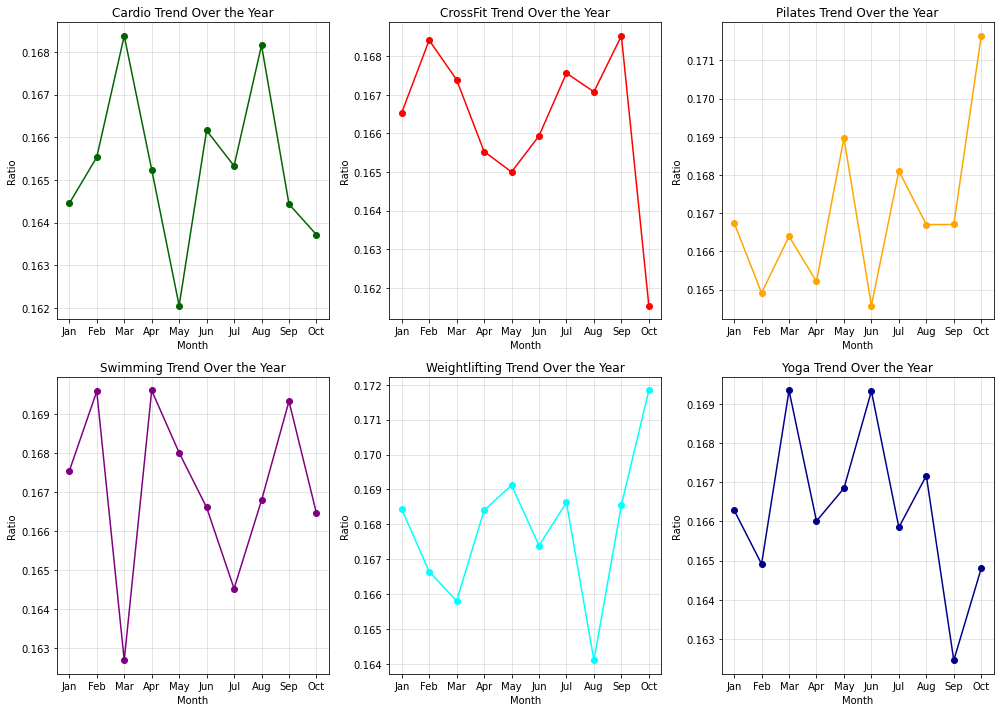

In [162]:
# Separate plots for each workout
workout_types = workout_trends['workout_type'].unique()
plt.figure(figsize=(14, 10))

# Loop through each workout type
colors = ['darkblue', 'darkgreen', 'red', 'orange', 'purple', 'cyan']
for i, workout in enumerate(workout_types, start=1):
    # Filter the data for the current workout type
    trend = workout_trends[workout_trends['workout_type'] == workout]
    
    # Create a subplot for each workout type
    plt.subplot(2, 3, i)  # Adjust the grid (2 rows, 3 columns)
    plt.plot(trend['month'], trend['ratio'], marker='o', label=workout, color=colors[i % len(colors)])
    plt.title(f"{workout} Trend Over the Year", loc='center')
    plt.xlabel('Month')
    plt.ylabel('Ratio')
    plt.xticks(range(1, 11), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'])
    plt.grid(alpha=0.4)

plt.tight_layout()
plt.show()

### 3. Standardize data for clustering

In [234]:
from sklearn.preprocessing import StandardScaler

# Merge checkin data and gym data to obtain a dataframe with CATEGORICAL value
workout_data = checkin_data.merge(user_data[['user_id', 'age']], on = 'user_id', how = 'left')
workout_data = workout_data.merge(gym_data['gym_id'], on = 'gym_id', how='left')
workout_data.drop(['checkout_time'], axis = 1, inplace = True) # Remove 'checkout_time' column - not interested to look at

workout_gym_counts = workout_data.groupby(['workout_type', 'gym_id']).size().reset_index(name='count')
workout_age_counts = workout_data.groupby(['age', 'workout_type', 'gym_id']).size().reset_index(name='count')
workout_age_counts = workout_age_counts.groupby(['age', 'workout_type'])['count'].sum().reset_index()

workout_gym_matrix = workout_gym_counts.pivot(index='workout_type', columns='gym_id', values='count').fillna(0)
workout_age_matrix = workout_age_counts.pivot(index='workout_type', columns='age', values='count').fillna(0)

# Standardize features for clustering
scaler = StandardScaler()
scaled_gym_features = scaler.fit_transform(workout_gym_matrix)
scaled_age_features = scaler.fit_transform(workout_age_matrix)



### 4. Determining optimal number of clusters, k

In [189]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

def determine_optimal_k(features, k_values):
    inertia_values = []
    silhouette_scores = []
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features)
        inertia_values.append(kmeans.inertia_)
        
        # Safeguard: Only calculate silhouette score if more than 1 cluster
        if len(np.unique(kmeans.labels_)) > 1:
            silhouette_scores.append(silhouette_score(features, kmeans.labels_))
        else:
            silhouette_scores.append(np.nan)  # Mark invalid scores as NaN
    
    # Return the scores
    return inertia_values, silhouette_scores

k_values = range(2, 5)
gym_inertia, gym_silhouette = determine_optimal_k(scaled_gym_features, k_values)
age_inertia, age_silhouette = determine_optimal_k(scaled_age_features, k_values)


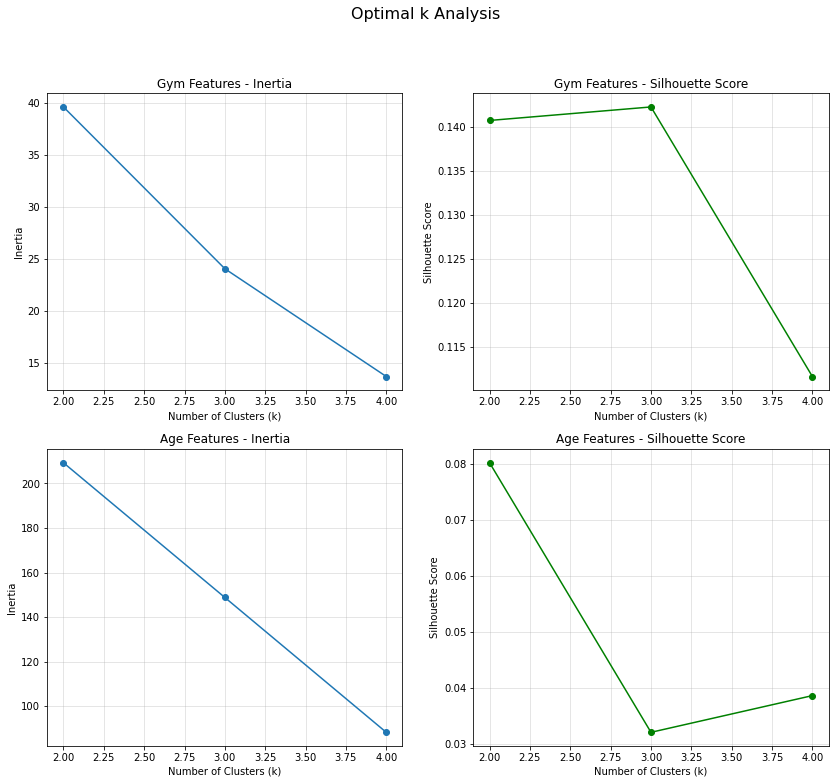

In [194]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle("Optimal k Analysis", fontsize=16)

# Gym Features - Inertia
axes[0, 0].plot(k_values, gym_inertia, marker='o', label="Inertia")
axes[0, 0].set_title("Gym Features - Inertia")
axes[0, 0].set_xlabel("Number of Clusters (k)")
axes[0, 0].set_ylabel("Inertia")
axes[0, 0].grid(alpha=0.4)

# Gym Features - Silhouette Score
axes[0, 1].plot(k_values, gym_silhouette, marker='o', label="Silhouette Score", color="green")
axes[0, 1].set_title("Gym Features - Silhouette Score")
axes[0, 1].set_xlabel("Number of Clusters (k)")
axes[0, 1].set_ylabel("Silhouette Score")
axes[0, 1].grid(alpha=0.4)

# Age Features - Inertia
axes[1, 0].plot(k_values, age_inertia, marker='o', label="Inertia")
axes[1, 0].set_title("Age Features - Inertia")
axes[1, 0].set_xlabel("Number of Clusters (k)")
axes[1, 0].set_ylabel("Inertia")
axes[1, 0].grid(alpha=0.4)

# Age Features - Silhouette Score
axes[1, 1].plot(k_values, age_silhouette, marker='o', label="Silhouette Score", color="green")
axes[1, 1].set_title("Age Features - Silhouette Score")
axes[1, 1].set_xlabel("Number of Clusters (k)")
axes[1, 1].set_ylabel("Silhouette Score")
axes[1, 1].grid(alpha=0.4)

For both features, gym and age, the optimal k = 3

In [232]:
from sklearn.cluster import KMeans

kmeans_gym = KMeans(n_clusters=6, random_state=42)
kmeans_age = KMeans(n_clusters=3, random_state=42)
labels_gym = kmeans_gym.fit_predict(scaled_gym_features)
labels_age = kmeans_age.fit_predict(scaled_age_features)

### 5. K-Means Analysis

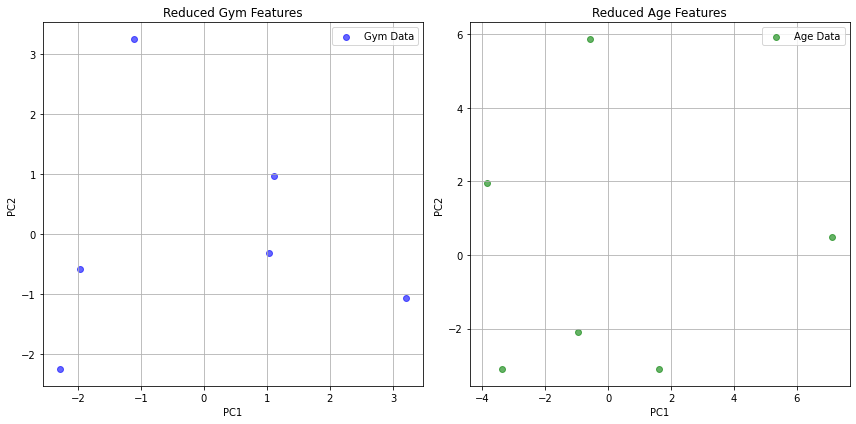

In [233]:
from sklearn.decomposition import PCA

# PCA for dimensionality reduction and visualization
pca = PCA(n_components=2)
reduced_gym_features = pca.fit_transform(scaled_gym_features)
reduced_age_features = pca.fit_transform(scaled_age_features)


# Plot reduced gym features
plt.figure(figsize=(12, 6))

# Gym Plot
plt.subplot(1, 2, 1)
plt.scatter(reduced_gym_features[:, 0], reduced_gym_features[:, 1], c='blue', alpha=0.6, label='Gym Data')
plt.title("Reduced Gym Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()

# Age Plot
plt.subplot(1, 2, 2)
plt.scatter(reduced_age_features[:, 0], reduced_age_features[:, 1], c='green', alpha=0.6, label='Age Data')
plt.title("Reduced Age Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
